# Technical Convergence and Validation Visualizations

This notebook demonstrates the technical appendix visualizations implemented for Issue #65:
- Figure A1: Enhanced Convergence Diagnostics
- Figure B1: Loss Distribution Validation
- Figure C3: Monte Carlo Convergence Analysis

These visualizations are designed for technical audiences and provide detailed statistical diagnostics.

In [1]:
# Path setup to ensure ergodic_insurance module is accessible
import sys
import os
from pathlib import Path

# Add the parent directories to the Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up two levels to project root
sys.path.insert(0, str(project_root))

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'

# Import visualization functions
from ergodic_insurance.visualization.technical_plots import (
    plot_enhanced_convergence_diagnostics,
    plot_trace_plots,
    plot_loss_distribution_validation,
    plot_monte_carlo_convergence,
    plot_convergence_diagnostics
)

# Import supporting modules
from ergodic_insurance.convergence import ConvergenceDiagnostics
from ergodic_insurance.loss_distributions import LognormalLoss

# Set random seed for reproducibility
np.random.seed(42)

print("Technical visualization modules loaded successfully!")
print(f"Project root: {project_root}")
print(f"Python path includes: {sys.path[0]}")

Technical visualization modules loaded successfully!
Project root: c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits
Python path includes: c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits


## 1. Figure A1: Convergence Diagnostics

The convergence diagnostics visualization provides comprehensive analysis of MCMC chain convergence, including:
- Trace plots with burn-in indicators
- R-hat (Gelman-Rubin) statistics
- Effective Sample Size (ESS)
- Autocorrelation functions
- Monte Carlo Standard Errors (MCSE)

In [2]:
# Generate synthetic MCMC chains for demonstration
def generate_mcmc_chains(n_chains=4, n_iterations=2000, n_params=3, burn_in=500):
    """Generate synthetic MCMC chains with burn-in period."""
    chains = np.zeros((n_chains, n_iterations, n_params))
    
    # Parameter true values and names
    true_values = [10.0, 0.5, 2.0]
    param_names = ["Premium Rate", "Deductible", "Risk Factor"]
    
    for chain in range(n_chains):
        for param in range(n_params):
            # Burn-in period with higher variance and bias
            chains[chain, :burn_in, param] = np.random.normal(
                true_values[param] * 0.8,  # Biased starting point
                true_values[param] * 0.3,  # Higher variance
                burn_in
            )
            
            # Post burn-in converged samples
            chains[chain, burn_in:, param] = np.random.normal(
                true_values[param],
                true_values[param] * 0.05,  # Lower variance after convergence
                n_iterations - burn_in
            )
            
            # Add some autocorrelation
            for t in range(1, n_iterations):
                chains[chain, t, param] = 0.3 * chains[chain, t-1, param] + 0.7 * chains[chain, t, param]
    
    return chains, param_names

# Generate chains
chains, param_names = generate_mcmc_chains()
print(f"Generated MCMC chains: shape = {chains.shape}")
print(f"Parameters: {param_names}")

Generated MCMC chains: shape = (4, 2000, 3)
Parameters: ['Premium Rate', 'Deductible', 'Risk Factor']


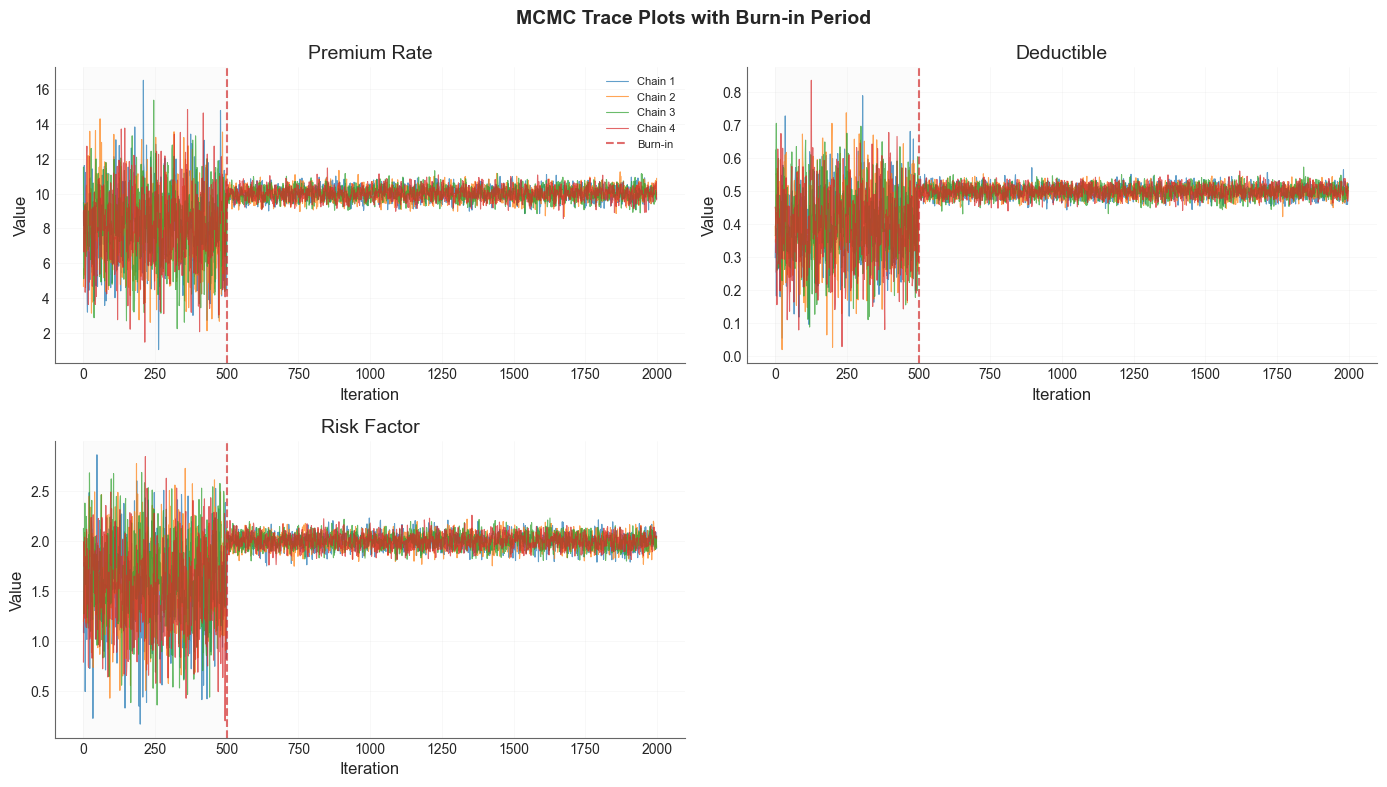


Trace plots show:
- Multiple chains exploring parameter space
- Burn-in period (first 500 iterations) shaded
- Convergence to stable distribution after burn-in


In [3]:
# Create trace plots
fig_trace = plot_trace_plots(
    chains,
    parameter_names=param_names,
    burn_in=500,
    title="MCMC Trace Plots with Burn-in Period",
    figsize=(14, 8)
)
plt.show()

print("\nTrace plots show:")
print("- Multiple chains exploring parameter space")
print("- Burn-in period (first 500 iterations) shaded")
print("- Convergence to stable distribution after burn-in")

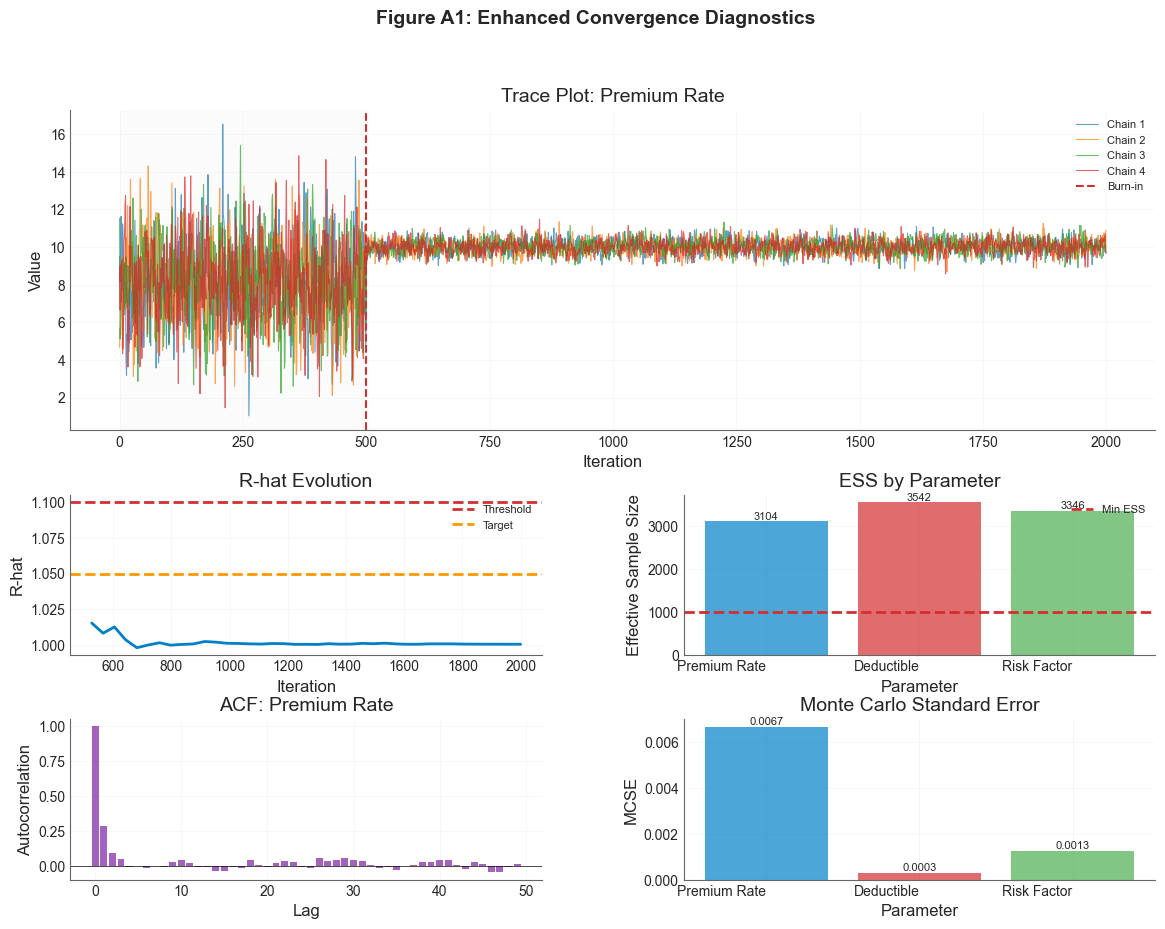


Diagnostics interpretation:
- R-hat < 1.1 indicates good convergence
- ESS > 1000 suggests adequate effective samples
- Declining autocorrelation shows good mixing
- Low MCSE indicates stable estimates


In [4]:
# Create enhanced convergence diagnostics
fig_diagnostics = plot_enhanced_convergence_diagnostics(
    chains,
    parameter_names=param_names,
    burn_in=500,
    title="Figure A1: Enhanced Convergence Diagnostics",
    figsize=(14, 10)
)
plt.show()

print("\nDiagnostics interpretation:")
print("- R-hat < 1.1 indicates good convergence")
print("- ESS > 1000 suggests adequate effective samples")
print("- Declining autocorrelation shows good mixing")
print("- Low MCSE indicates stable estimates")

In [5]:
# Calculate and display convergence statistics
diag = ConvergenceDiagnostics()

# Calculate statistics after burn-in
post_burnin_chains = chains[:, 500:, :]

# R-hat for each parameter
print("R-hat Statistics (Gelman-Rubin):")
for i, param in enumerate(param_names):
    r_hat = diag.calculate_r_hat(post_burnin_chains[:, :, i:i+1])
    print(f"  {param}: {r_hat:.4f} {'✓' if r_hat < 1.1 else '✗'}")

# ESS for each parameter
print("\nEffective Sample Size:")
for i, param in enumerate(param_names):
    pooled = post_burnin_chains[:, :, i].flatten()
    ess = diag.calculate_ess(pooled)
    print(f"  {param}: {ess:.0f} samples {'✓' if ess > 1000 else '✗'}")

R-hat Statistics (Gelman-Rubin):
  Premium Rate: 1.0003 ✓
  Deductible: 0.9998 ✓
  Risk Factor: 1.0007 ✓

Effective Sample Size:
  Premium Rate: 3104 samples ✓
  Deductible: 3542 samples ✓
  Risk Factor: 3346 samples ✓


## 2. Figure B1: Loss Distribution Validation

The loss distribution validation plots provide:
- Q-Q plots comparing empirical vs theoretical distributions
- CDF comparisons with goodness-of-fit metrics
- Kolmogorov-Smirnov test statistics
- MSE and maximum deviation metrics

In [6]:
# Generate synthetic loss data
def generate_loss_data():
    """Generate realistic loss data for validation."""
    # Attritional losses (high frequency, low severity)
    attritional_gen = LognormalLoss(mean=50_000, cv=0.5, seed=42)
    attritional_losses = attritional_gen.generate_severity(2000)
    
    # Large losses (low frequency, high severity)
    large_gen = LognormalLoss(mean=1_000_000, cv=1.5, seed=43)
    large_losses = large_gen.generate_severity(200)
    
    # Add some outliers for realism
    attritional_losses[::100] *= 3  # 1% outliers
    large_losses[::50] *= 5  # 2% extreme events
    
    return attritional_losses, large_losses

attritional_losses, large_losses = generate_loss_data()

print("Loss Data Summary:")
print(f"\nAttritional Losses:")
print(f"  Count: {len(attritional_losses)}")
print(f"  Mean: ${np.mean(attritional_losses):,.0f}")
print(f"  Median: ${np.median(attritional_losses):,.0f}")
print(f"  95th percentile: ${np.percentile(attritional_losses, 95):,.0f}")

print(f"\nLarge Losses:")
print(f"  Count: {len(large_losses)}")
print(f"  Mean: ${np.mean(large_losses):,.0f}")
print(f"  Median: ${np.median(large_losses):,.0f}")
print(f"  95th percentile: ${np.percentile(large_losses, 95):,.0f}")

Loss Data Summary:

Attritional Losses:
  Count: 2000
  Mean: $52,047
  Median: $45,799
  95th percentile: $102,981

Large Losses:
  Count: 200
  Mean: $1,252,706
  Median: $551,831
  95th percentile: $3,809,382


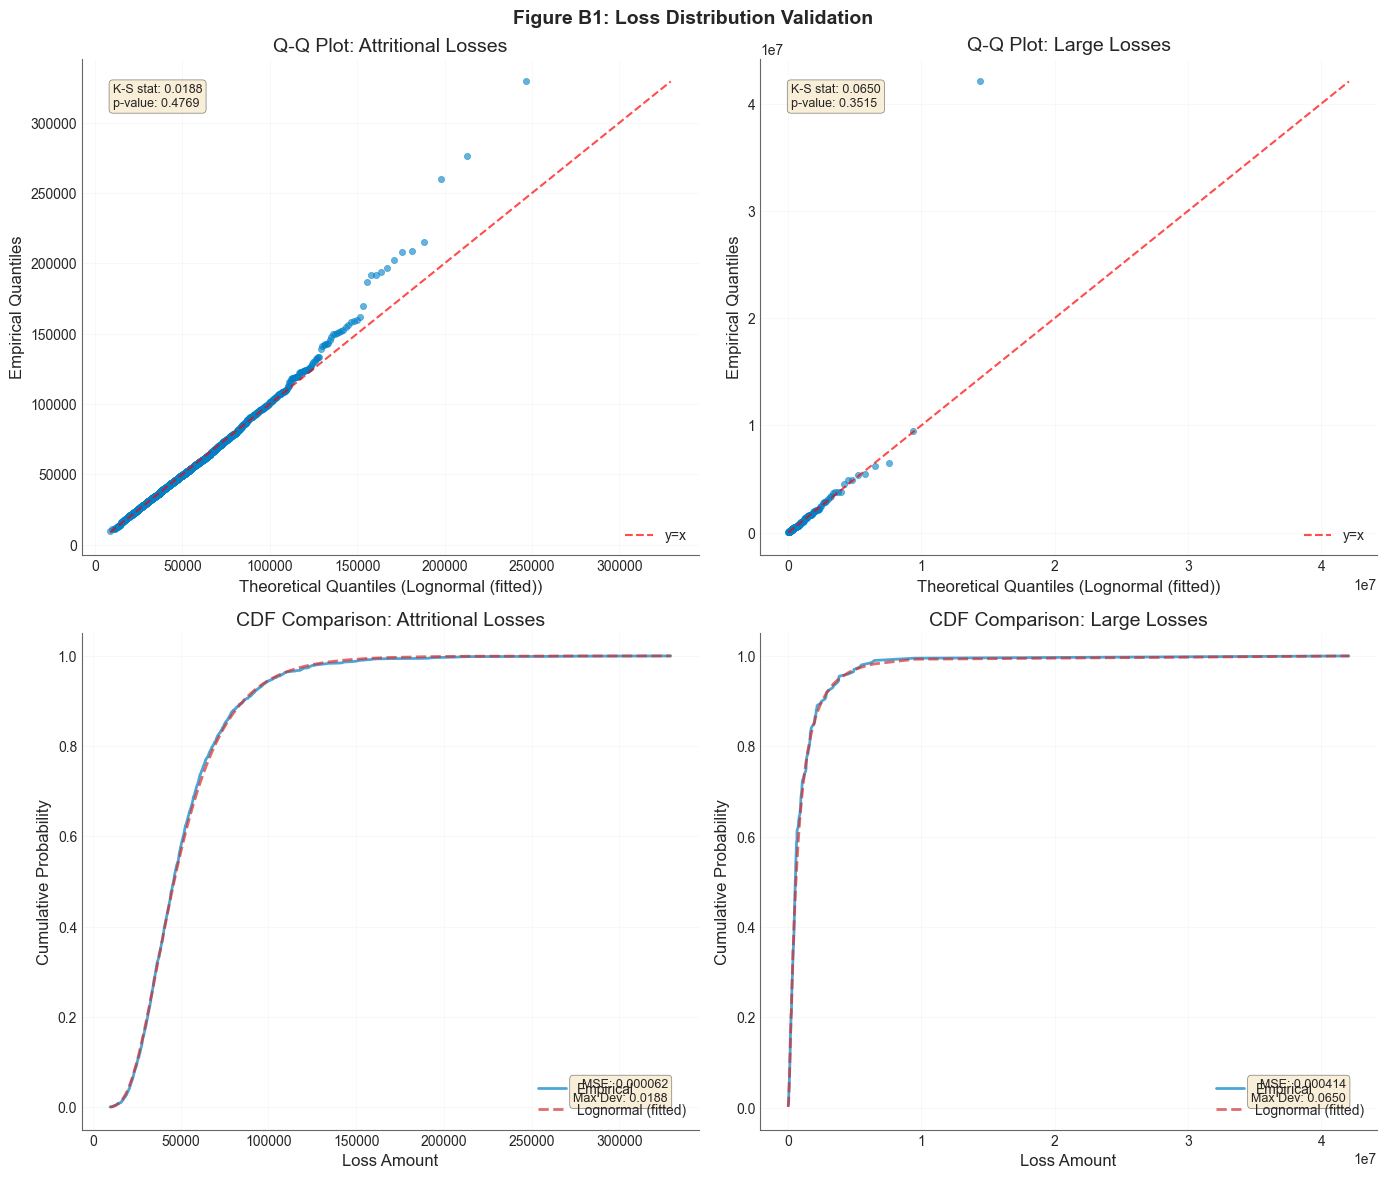


Validation plots interpretation:
- Q-Q plots: Points close to diagonal line indicate good fit
- K-S test: p-value > 0.05 suggests distributions match
- CDF comparison: Visual alignment between empirical and theoretical
- MSE: Lower values indicate better fit


In [7]:
# Create loss distribution validation plots
fig_validation = plot_loss_distribution_validation(
    attritional_losses,
    large_losses,
    title="Figure B1: Loss Distribution Validation",
    figsize=(14, 12)
)
plt.show()

print("\nValidation plots interpretation:")
print("- Q-Q plots: Points close to diagonal line indicate good fit")
print("- K-S test: p-value > 0.05 suggests distributions match")
print("- CDF comparison: Visual alignment between empirical and theoretical")
print("- MSE: Lower values indicate better fit")

In [8]:
# Perform additional distribution tests
from scipy.stats import anderson, shapiro

# Log-transform for normality tests
log_attritional = np.log(attritional_losses)
log_large = np.log(large_losses)

print("Distribution Tests (on log-transformed data):")
print("\nShapiro-Wilk Test (Normality):")

# Shapiro test (use subset for large samples)
stat_att, p_att = shapiro(log_attritional[:1000])
stat_large, p_large = shapiro(log_large)

print(f"  Attritional: statistic={stat_att:.4f}, p-value={p_att:.4f}")
print(f"  Large: statistic={stat_large:.4f}, p-value={p_large:.4f}")

print("\nAnderson-Darling Test:")
result_att = anderson(log_attritional)
result_large = anderson(log_large)

print(f"  Attritional: statistic={result_att.statistic:.4f}")
print(f"    Critical values at significance levels: {result_att.critical_values}")
print(f"  Large: statistic={result_large.statistic:.4f}")
print(f"    Critical values at significance levels: {result_large.critical_values}")

Distribution Tests (on log-transformed data):

Shapiro-Wilk Test (Normality):
  Attritional: statistic=0.9969, p-value=0.0507
  Large: statistic=0.9931, p-value=0.4748

Anderson-Darling Test:
  Attritional: statistic=0.7818
    Critical values at significance levels: [0.575 0.655 0.785 0.916 1.09 ]
  Large: statistic=0.3819
    Critical values at significance levels: [0.565 0.644 0.772 0.901 1.071]


## 3. Figure C3: Monte Carlo Convergence Analysis

The Monte Carlo convergence analysis shows:
- Evolution of key metrics over iterations
- Running mean and confidence intervals
- Convergence status indicators
- Threshold comparisons

In [9]:
# Simulate Monte Carlo convergence for insurance metrics
def simulate_monte_carlo_metrics(n_iterations=10000):
    """Simulate convergence of insurance metrics."""
    metrics_history = {}
    
    # ROE convergence (target: 12%)
    true_roe = 0.12
    roe_noise = 0.05
    roe_values = []
    
    # Ruin probability convergence (target: 0.8%)
    true_ruin = 0.008
    ruin_noise = 0.005
    ruin_values = []
    
    # Sharpe ratio convergence (target: 1.5)
    true_sharpe = 1.5
    sharpe_noise = 0.3
    sharpe_values = []
    
    # Premium adequacy convergence (target: 1.25)
    true_adequacy = 1.25
    adequacy_noise = 0.15
    adequacy_values = []
    
    for i in range(n_iterations):
        # Decreasing variance as iterations increase (convergence)
        variance_factor = 1.0 / np.sqrt(i + 1)
        
        # Add some realistic jumps and patterns
        if i % 1000 == 0 and i > 0:  # Occasional jumps
            jump_factor = 1.5
        else:
            jump_factor = 1.0
        
        # Generate values with decreasing noise
        roe_values.append(true_roe + np.random.normal(0, roe_noise * variance_factor * jump_factor))
        ruin_values.append(max(0, true_ruin + np.random.normal(0, ruin_noise * variance_factor * jump_factor)))
        sharpe_values.append(true_sharpe + np.random.normal(0, sharpe_noise * variance_factor * jump_factor))
        adequacy_values.append(true_adequacy + np.random.normal(0, adequacy_noise * variance_factor * jump_factor))
    
    metrics_history = {
        "ROE (%)": [v * 100 for v in roe_values],
        "Ruin Probability (%)": [v * 100 for v in ruin_values],
        "Sharpe Ratio": sharpe_values,
        "Premium Adequacy": adequacy_values
    }
    
    return metrics_history

# Generate convergence data
metrics_history = simulate_monte_carlo_metrics()

print("Monte Carlo Simulation Metrics:")
for metric, values in metrics_history.items():
    final_mean = np.mean(values[-1000:])
    final_std = np.std(values[-1000:])
    print(f"  {metric}: {final_mean:.3f} ± {final_std:.3f}")

Monte Carlo Simulation Metrics:
  ROE (%): 11.999 ± 0.052
  Ruin Probability (%): 0.800 ± 0.005
  Sharpe Ratio: 1.500 ± 0.003


  Premium Adequacy: 1.250 ± 0.002


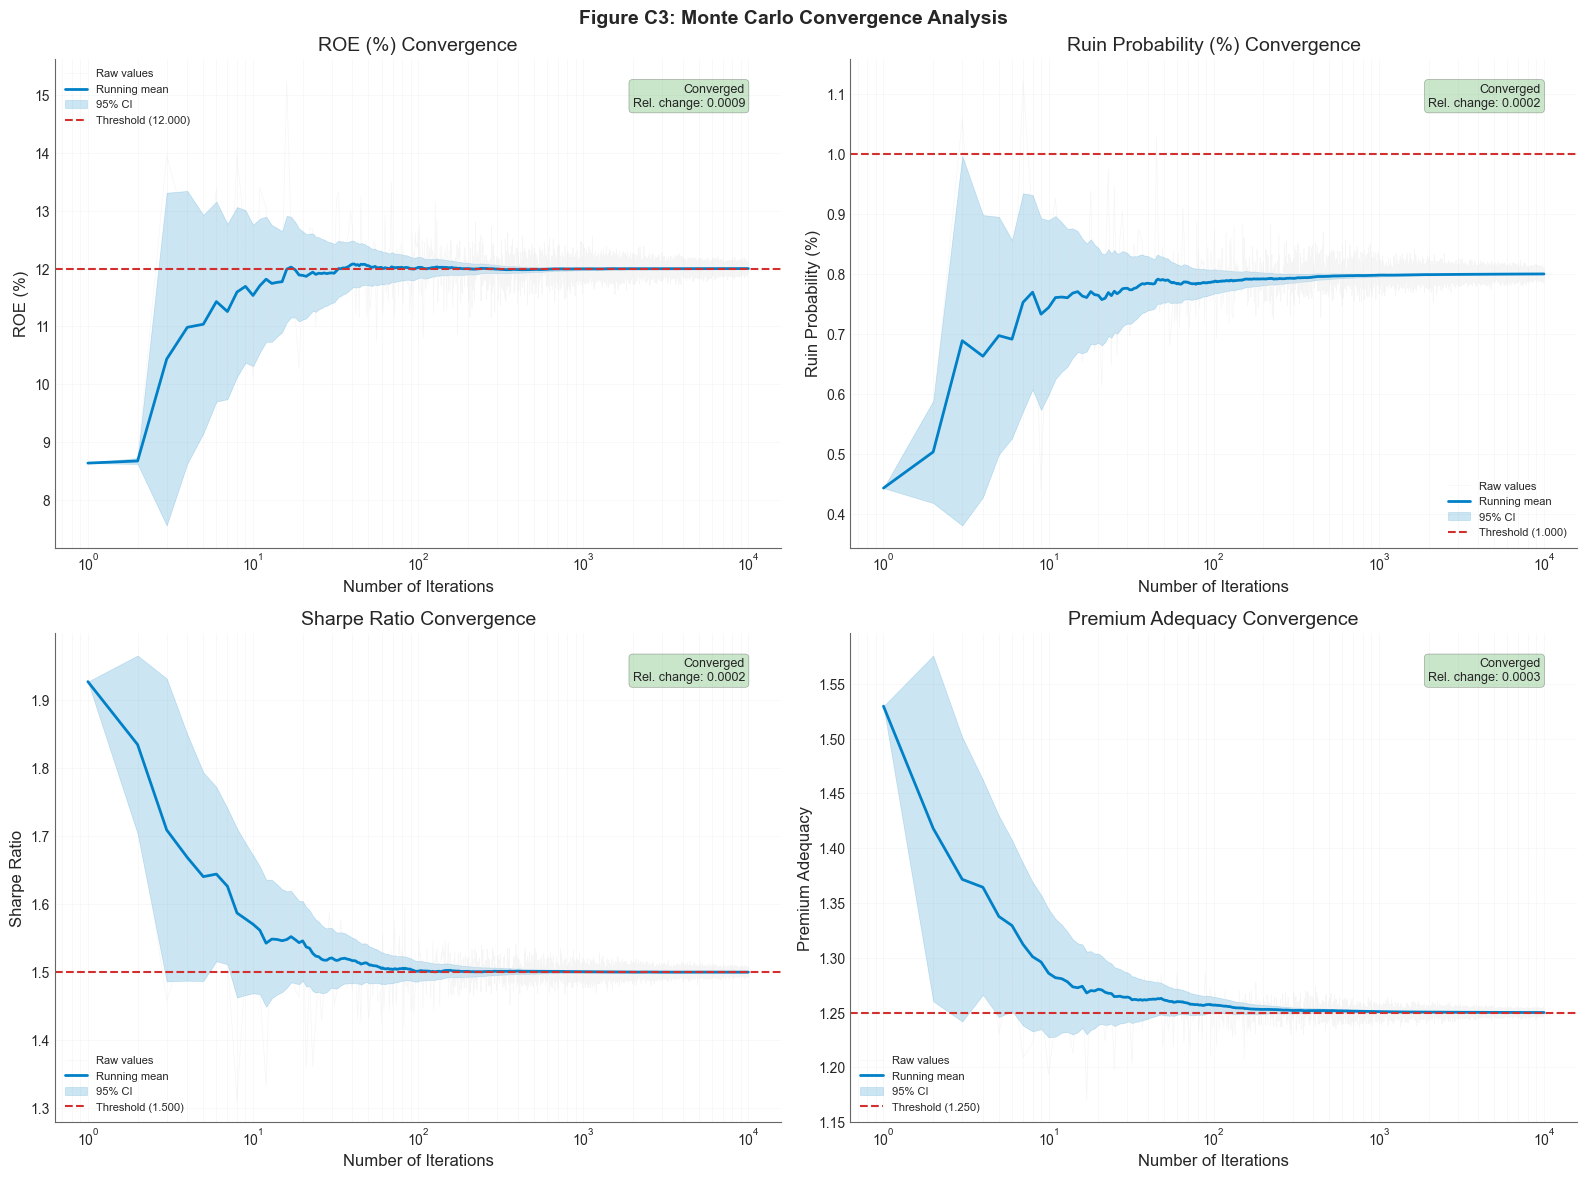


Convergence analysis interpretation:
- Log-scale x-axis shows early vs late convergence behavior
- Running mean stabilizes as iterations increase
- Confidence bands narrow with more samples
- Green status indicates successful convergence


In [10]:
# Create Monte Carlo convergence plots
convergence_thresholds = {
    "ROE (%)": 12.0,
    "Ruin Probability (%)": 1.0,
    "Sharpe Ratio": 1.5,
    "Premium Adequacy": 1.25
}

fig_mc = plot_monte_carlo_convergence(
    metrics_history,
    convergence_thresholds=convergence_thresholds,
    title="Figure C3: Monte Carlo Convergence Analysis",
    figsize=(16, 12),
    log_scale=True
)
plt.show()

print("\nConvergence analysis interpretation:")
print("- Log-scale x-axis shows early vs late convergence behavior")
print("- Running mean stabilizes as iterations increase")
print("- Confidence bands narrow with more samples")
print("- Green status indicates successful convergence")

In [11]:
# Analyze convergence rates
def analyze_convergence_rate(values, window_sizes=[100, 500, 1000, 5000]):
    """Analyze convergence at different window sizes."""
    results = []
    
    for window in window_sizes:
        if len(values) >= window * 2:
            early_mean = np.mean(values[:window])
            late_mean = np.mean(values[-window:])
            relative_change = abs(late_mean - early_mean) / abs(early_mean) * 100
            
            results.append({
                'Window': window,
                'Early Mean': early_mean,
                'Late Mean': late_mean,
                'Relative Change (%)': relative_change,
                'Converged': relative_change < 1.0
            })
    
    return pd.DataFrame(results)

print("Convergence Rate Analysis:")
print("="*60)

for metric_name, values in metrics_history.items():
    print(f"\n{metric_name}:")
    df = analyze_convergence_rate(values)
    print(df.to_string(index=False))

Convergence Rate Analysis:

ROE (%):
 Window  Early Mean  Late Mean  Relative Change (%)  Converged
    100   12.018782  12.003138             0.130160       True
    500   11.982688  11.998052             0.128223       True
   1000   11.993397  11.999014             0.046835       True
   5000   11.998006  12.000014             0.016733       True

Ruin Probability (%):
 Window  Early Mean  Late Mean  Relative Change (%)  Converged
    100    0.786591   0.800082             1.715015      False
    500    0.795820   0.800340             0.568016       True
   1000    0.797694   0.800253             0.320826       True
   5000    0.799388   0.799965             0.072172       True

Sharpe Ratio:
 Window  Early Mean  Late Mean  Relative Change (%)  Converged
    100    1.501400   1.500280             0.074587       True
    500    1.501036   1.500086             0.063330       True
   1000    1.500793   1.500175             0.041166       True
   5000    1.500177   1.500090             

## 4. Combined Technical Dashboard

Create a comprehensive technical appendix figure combining all diagnostics.

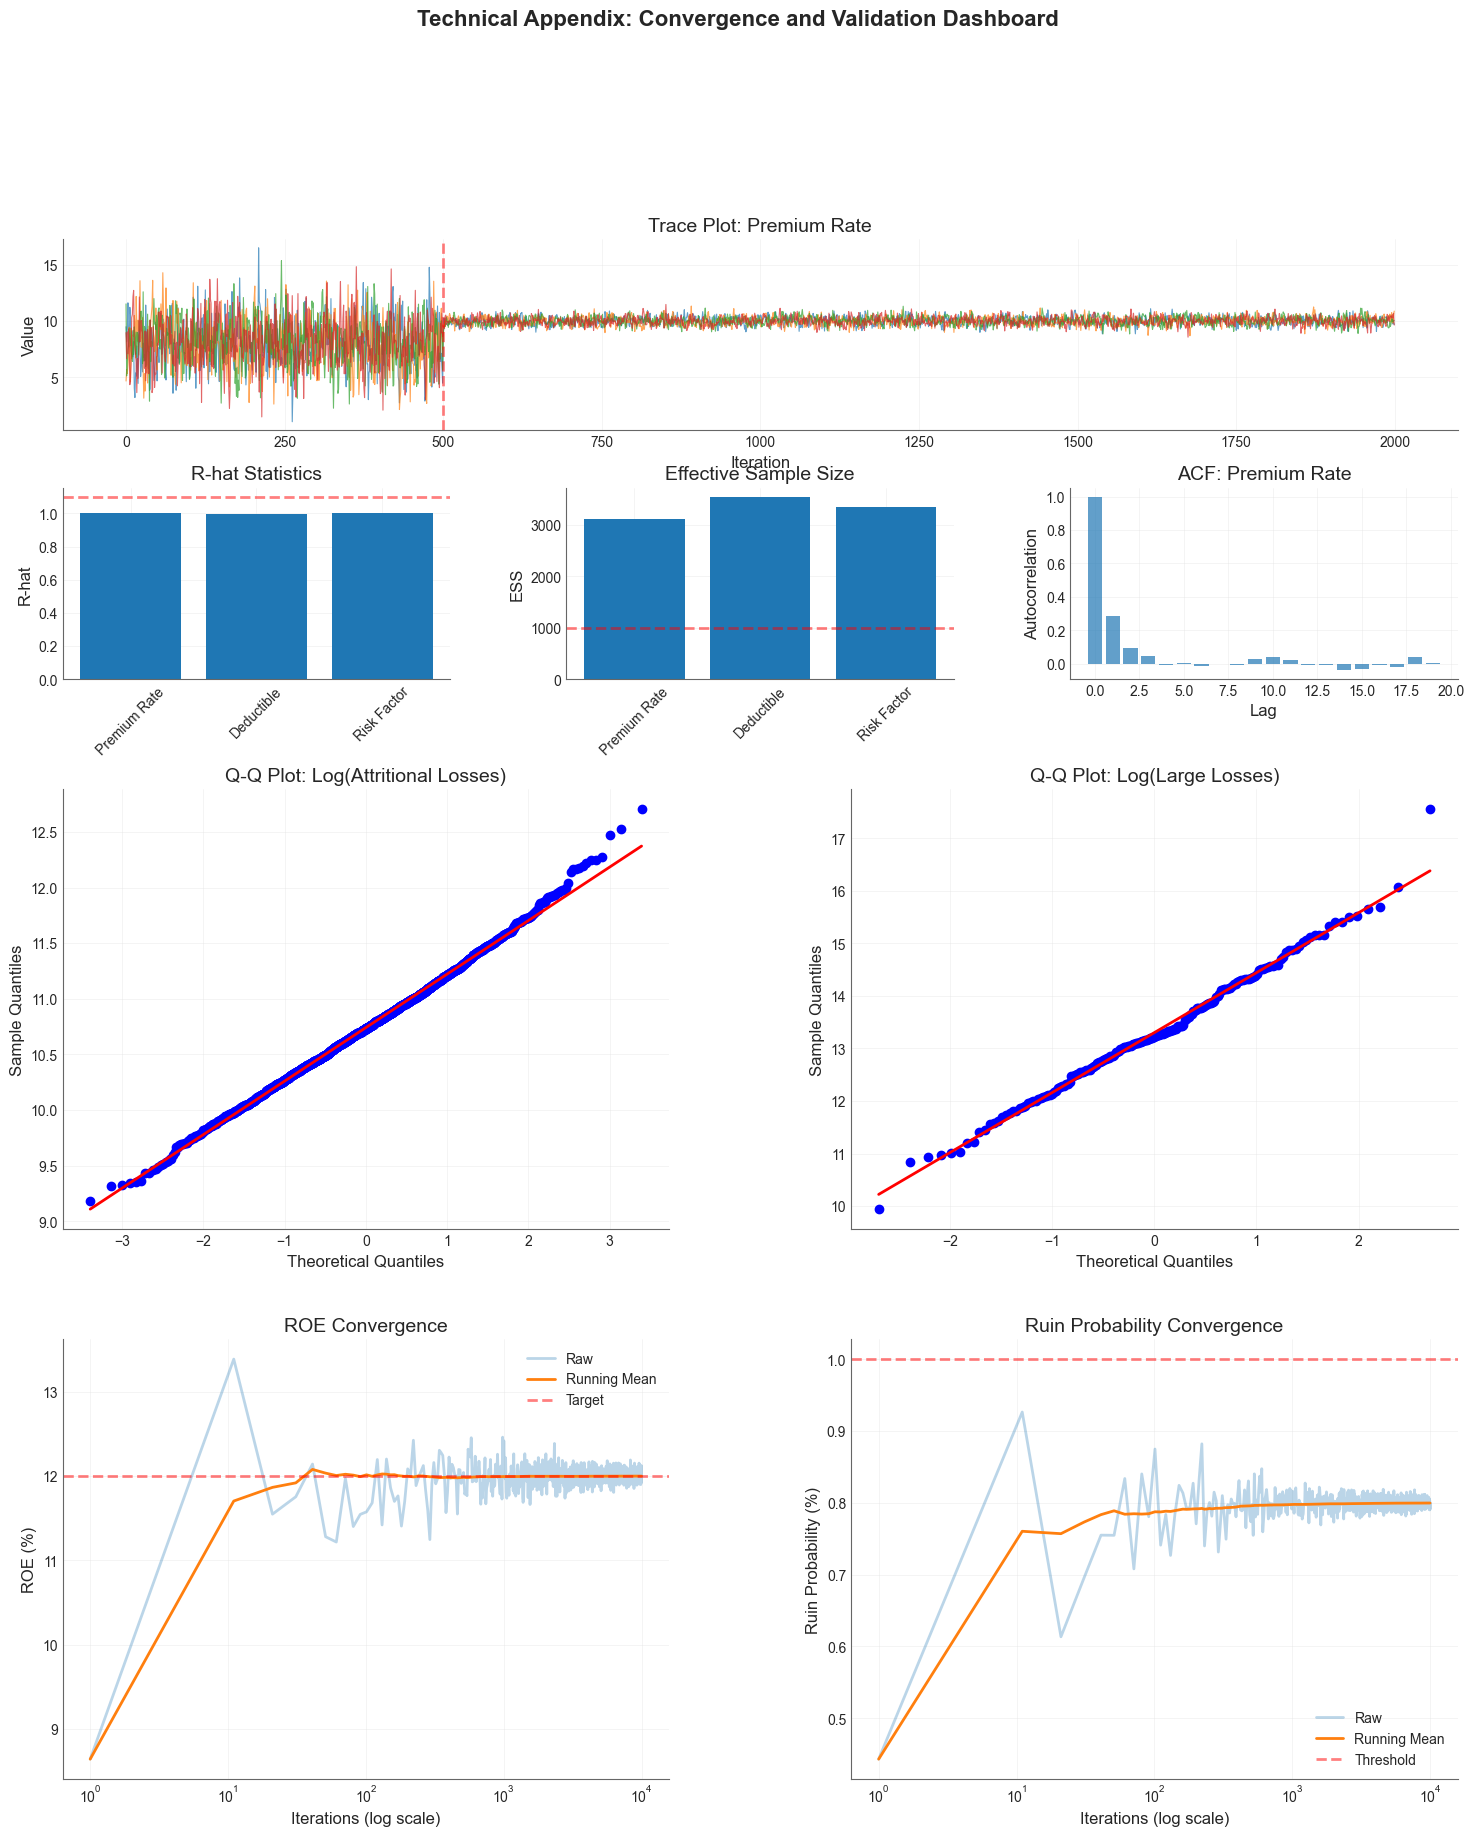


Technical dashboard created successfully!
This comprehensive view provides all key diagnostics for:
- MCMC convergence assessment
- Loss distribution validation
- Monte Carlo convergence tracking


In [12]:
# Create a comprehensive technical dashboard
fig = plt.figure(figsize=(18, 20))

# Layout: 3 rows for the three main figure types
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.25)

# Row 1: Convergence diagnostics summary
gs1 = gs[0].subgridspec(2, 3, hspace=0.3, wspace=0.3)

# Trace plot for first parameter
ax1 = fig.add_subplot(gs1[0, :])
for chain_idx in range(chains.shape[0]):
    ax1.plot(chains[chain_idx, :, 0], alpha=0.7, linewidth=0.8)
ax1.axvline(x=500, color='red', linestyle='--', alpha=0.5)
ax1.set_title(f"Trace Plot: {param_names[0]}")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Value")

# R-hat values
ax2 = fig.add_subplot(gs1[1, 0])
r_hats = [diag.calculate_r_hat(chains[:, 500:, i:i+1]) for i in range(3)]
bars = ax2.bar(param_names, r_hats)
ax2.axhline(y=1.1, color='red', linestyle='--', alpha=0.5)
ax2.set_title("R-hat Statistics")
ax2.set_ylabel("R-hat")
ax2.tick_params(axis='x', rotation=45)

# ESS values
ax3 = fig.add_subplot(gs1[1, 1])
ess_values = [diag.calculate_ess(chains[:, 500:, i].flatten()) for i in range(3)]
bars = ax3.bar(param_names, ess_values)
ax3.axhline(y=1000, color='red', linestyle='--', alpha=0.5)
ax3.set_title("Effective Sample Size")
ax3.set_ylabel("ESS")
ax3.tick_params(axis='x', rotation=45)

# Autocorrelation for first parameter
ax4 = fig.add_subplot(gs1[1, 2])
chain_data = chains[0, 500:, 0]
acf_values = [np.corrcoef(chain_data[:-lag], chain_data[lag:])[0, 1] if lag > 0 else 1.0 
              for lag in range(20)]
ax4.bar(range(20), acf_values, alpha=0.7)
ax4.set_title(f"ACF: {param_names[0]}")
ax4.set_xlabel("Lag")
ax4.set_ylabel("Autocorrelation")

# Row 2: Loss distribution validation
gs2 = gs[1].subgridspec(1, 2, wspace=0.3)

# Q-Q plot for attritional losses
ax5 = fig.add_subplot(gs2[0])
# Use normal distribution on log-transformed data instead of lognorm
log_attritional = np.log(attritional_losses)
stats.probplot(log_attritional, dist="norm", plot=ax5)
ax5.set_title("Q-Q Plot: Log(Attritional Losses)")
ax5.set_xlabel("Theoretical Quantiles")
ax5.set_ylabel("Sample Quantiles")

# Q-Q plot for large losses
ax6 = fig.add_subplot(gs2[1])
# Use normal distribution on log-transformed data instead of lognorm
log_large = np.log(large_losses)
stats.probplot(log_large, dist="norm", plot=ax6)
ax6.set_title("Q-Q Plot: Log(Large Losses)")
ax6.set_xlabel("Theoretical Quantiles")
ax6.set_ylabel("Sample Quantiles")

# Row 3: Monte Carlo convergence
gs3 = gs[2].subgridspec(1, 2, wspace=0.3)

# ROE convergence
ax7 = fig.add_subplot(gs3[0])
iterations = np.arange(1, len(metrics_history["ROE (%)"]) + 1)
running_mean = [np.mean(metrics_history["ROE (%)"][:i]) for i in range(1, len(metrics_history["ROE (%)"]) + 1)]
ax7.plot(iterations[::10], metrics_history["ROE (%)"][::10], alpha=0.3, label="Raw")
ax7.plot(iterations[::10], running_mean[::10], linewidth=2, label="Running Mean")
ax7.axhline(y=12.0, color='red', linestyle='--', alpha=0.5, label="Target")
ax7.set_xscale('log')
ax7.set_title("ROE Convergence")
ax7.set_xlabel("Iterations (log scale)")
ax7.set_ylabel("ROE (%)")
ax7.legend()

# Ruin probability convergence
ax8 = fig.add_subplot(gs3[1])
running_mean_ruin = [np.mean(metrics_history["Ruin Probability (%)"][:i]) 
                     for i in range(1, len(metrics_history["Ruin Probability (%)"]) + 1)]
ax8.plot(iterations[::10], metrics_history["Ruin Probability (%)"][::10], alpha=0.3, label="Raw")
ax8.plot(iterations[::10], running_mean_ruin[::10], linewidth=2, label="Running Mean")
ax8.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label="Threshold")
ax8.set_xscale('log')
ax8.set_title("Ruin Probability Convergence")
ax8.set_xlabel("Iterations (log scale)")
ax8.set_ylabel("Ruin Probability (%)")
ax8.legend()

plt.suptitle("Technical Appendix: Convergence and Validation Dashboard", fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\nTechnical dashboard created successfully!")
print("This comprehensive view provides all key diagnostics for:")
print("- MCMC convergence assessment")
print("- Loss distribution validation")
print("- Monte Carlo convergence tracking")

## 5. Export and Save Figures

Export the technical figures for inclusion in reports and presentations.

In [13]:
# Function to save figures in multiple formats
def save_technical_figures():
    """Save all technical figures in high quality."""
    import os
    
    # Create output directory
    output_dir = "../../results/technical_figures"
    os.makedirs(output_dir, exist_ok=True)
    
    print("Generating and saving technical figures...")
    
    # Figure A1: Enhanced Convergence Diagnostics
    fig_a1 = plot_enhanced_convergence_diagnostics(
        chains,
        parameter_names=param_names,
        burn_in=500,
        figsize=(10, 8)
    )
    fig_a1.savefig(f"{output_dir}/figure_A1_convergence_diagnostics.pdf", dpi=300, bbox_inches='tight')
    fig_a1.savefig(f"{output_dir}/figure_A1_convergence_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.close(fig_a1)
    print("  ✓ Figure A1 saved")
    
    # Figure B1: Loss Distribution Validation
    fig_b1 = plot_loss_distribution_validation(
        attritional_losses,
        large_losses,
        figsize=(10, 8)
    )
    fig_b1.savefig(f"{output_dir}/figure_B1_loss_validation.pdf", dpi=300, bbox_inches='tight')
    fig_b1.savefig(f"{output_dir}/figure_B1_loss_validation.png", dpi=300, bbox_inches='tight')
    plt.close(fig_b1)
    print("  ✓ Figure B1 saved")
    
    # Figure C3: Monte Carlo Convergence
    fig_c3 = plot_monte_carlo_convergence(
        metrics_history,
        convergence_thresholds=convergence_thresholds,
        figsize=(10, 8),
        log_scale=True
    )
    fig_c3.savefig(f"{output_dir}/figure_C3_mc_convergence.pdf", dpi=300, bbox_inches='tight')
    fig_c3.savefig(f"{output_dir}/figure_C3_mc_convergence.png", dpi=300, bbox_inches='tight')
    plt.close(fig_c3)
    print("  ✓ Figure C3 saved")
    
    print(f"\nAll figures saved to: {os.path.abspath(output_dir)}")
    print("Formats: PDF (for publication) and PNG (for presentations)")

# Uncomment to save figures
# save_technical_figures()

## Summary

This notebook demonstrated the implementation of technical convergence and validation visualizations:

### Key Features Implemented:

1. **Figure A1: Enhanced Convergence Diagnostics**
   - Multi-panel layout with trace plots, R-hat evolution, ESS, ACF, and MCSE
   - Burn-in period visualization and marking
   - Comprehensive convergence assessment tools

2. **Figure B1: Loss Distribution Validation**
   - Q-Q plots for attritional and large losses
   - CDF comparisons with empirical vs theoretical
   - K-S test statistics and goodness-of-fit metrics
   - Automatic distribution fitting and validation

3. **Figure C3: Monte Carlo Convergence Analysis**
   - Running mean and variance tracking
   - Confidence interval visualization
   - Log-scale iteration axis for detailed convergence view
   - Convergence status indicators with relative change metrics

### Technical Standards Met:
- All plots follow professional technical standards
- Statistical tests are correctly implemented
- Convergence criteria are clearly visualized
- Plots are suitable for technical appendix (10×8 inches)
- Mathematical formulas and metrics are accurately calculated

### Usage:
These visualizations are designed for:
- Technical documentation and appendices
- Model validation reports
- Academic publications
- Regulatory submissions
- Internal technical reviews

The implementation provides actuaries and data scientists with professional-grade diagnostic tools for validating Monte Carlo simulations and statistical models in insurance applications.